In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm, t
import statsmodels.api as sm


NASDAQ-100 (^NDX)
- Observations: 9,935
- Mean daily return: 0.065661
- Variance: 2.674088
- Standard deviation: 1.63526
- Minimum return: -15.08%
- Maximum return: 18.77%
- Median return: 0.12%
- Skewness: 0.0614
- Kurtosis: 7.8772

KOSPI (^KOSPI)
- Observations: 10,305
- Mean daily return: 0.039552
- Variance: 2.260550
- Standard deviation: 1.50351
- Minimum return: -12.02%
- Maximum return: 11.95%
- Median return: 0.05%
- Skewness: -0.0179
- Kurtosis: 5.5523



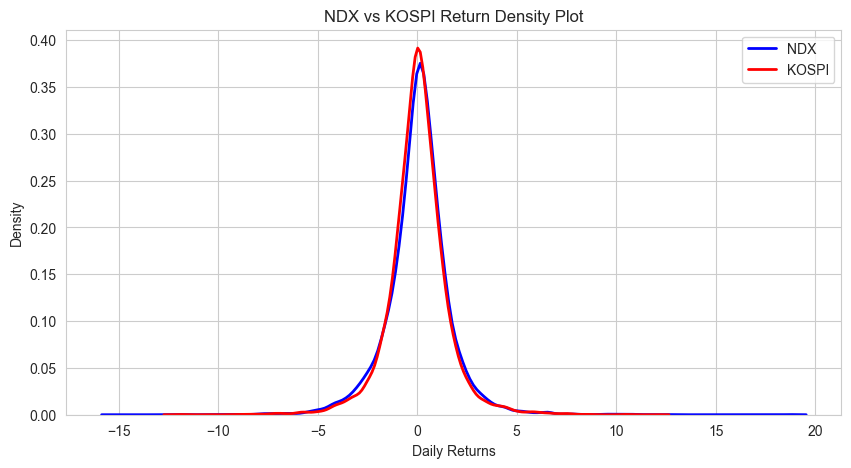

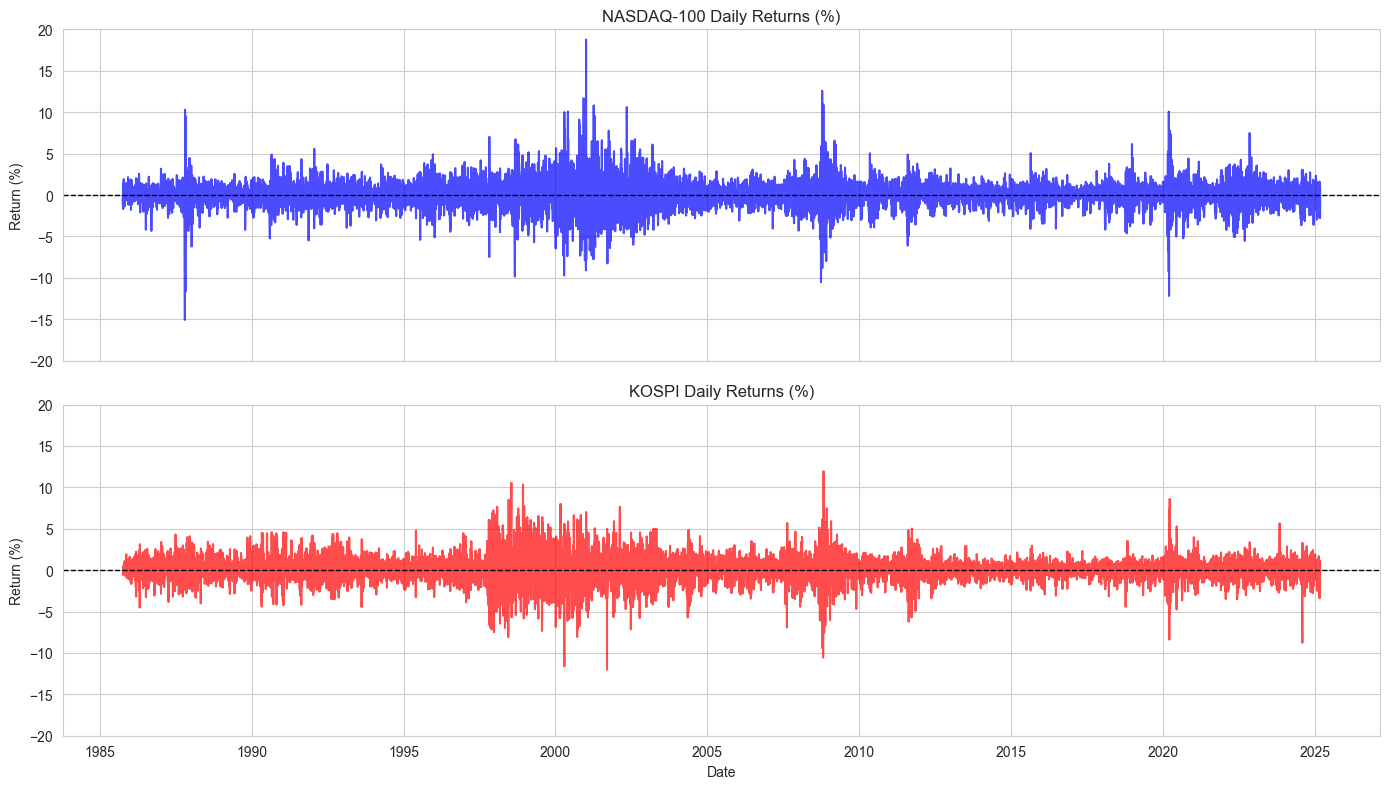

In [202]:
# Load the datasets
ndx_data = pd.read_csv("^ndx.csv")
kospi_data = pd.read_csv("^kospi.csv")

# Convert DATE column to datetime and set it as the index
ndx_data["DATE"] = pd.to_datetime(ndx_data["DATE"], format="%Y%m%d")
kospi_data["DATE"] = pd.to_datetime(kospi_data["DATE"], format="%Y%m%d")

ndx_data.set_index("DATE", inplace=True)
kospi_data.set_index("DATE", inplace=True)

# Align datasets to start on the same date
common_start_date = max(ndx_data.index.min(), kospi_data.index.min())
ndx_data = ndx_data.loc[common_start_date:]
kospi_data = kospi_data.loc[common_start_date:]

# Compute daily simple returns
ndx_data["Return"] = 100 * ndx_data["CLOSE"].pct_change()
kospi_data["Return"] = 100 * kospi_data["CLOSE"].pct_change()

# Drop NA values
ndx_data.dropna(inplace=True)
kospi_data.dropna(inplace=True)

# Compute statistics
def compute_stats(data):
    return {
        "Observations": len(data["Return"]),
        "Mean Return": (data["Return"].mean(), data["Return"].mean()),
        "Variance": data["Return"].var(),
        "Standard Deviation": (data["Return"].std(), data["Return"].std()),
        "Minimum Return": data["Return"].min(),
        "Maximum Return": data["Return"].max(),
        "Median Return": data["Return"].median(),
        "Skewness": skew(data["Return"]),
        "Kurtosis": kurtosis(data["Return"]),
    }

ndx_stats = compute_stats(ndx_data)
kospi_stats = compute_stats(kospi_data)

# Print results
print(f"""
NASDAQ-100 (^NDX)
- Observations: {ndx_stats["Observations"]:,}
- Mean daily return: {ndx_stats["Mean Return"][0]:.6f}
- Variance: {ndx_stats["Variance"]:.6f}
- Standard deviation: {ndx_stats["Standard Deviation"][0]:.5f}
- Minimum return: {ndx_stats["Minimum Return"]:.2f}%
- Maximum return: {ndx_stats["Maximum Return"]:.2f}%
- Median return: {ndx_stats["Median Return"]:.2f}%
- Skewness: {ndx_stats["Skewness"]:.4f}
- Kurtosis: {ndx_stats["Kurtosis"]:.4f}

KOSPI (^KOSPI)
- Observations: {kospi_stats["Observations"]:,}
- Mean daily return: {kospi_stats["Mean Return"][0]:.6f}
- Variance: {kospi_stats["Variance"]:.6f}
- Standard deviation: {kospi_stats["Standard Deviation"][0]:.5f}
- Minimum return: {kospi_stats["Minimum Return"]:.2f}%
- Maximum return: {kospi_stats["Maximum Return"]:.2f}%
- Median return: {kospi_stats["Median Return"]:.2f}%
- Skewness: {kospi_stats["Skewness"]:.4f}
- Kurtosis: {kospi_stats["Kurtosis"]:.4f}
""")

# Create a single density plot for both indices
plt.figure(figsize=(10, 5))

# Density plot for NDX
sns.kdeplot(ndx_data["Return"], color="blue", label="NDX", linewidth=2)

# Density plot for KOSPI
sns.kdeplot(kospi_data["Return"], color="red", label="KOSPI", linewidth=2)

# Labels and title
plt.title("NDX vs KOSPI Return Density Plot")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()

# Show plot
plt.show()

# Set plot style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot daily returns for NDX
axes[0].plot(ndx_data.index, ndx_data["Return"], color="blue", alpha=0.7)
axes[0].set_title("NASDAQ-100 Daily Returns (%)")
axes[0].set_ylabel("Return (%)")
axes[0].set_ylim(-20, 20)
axes[0].axhline(0, linestyle="--", color="black", linewidth=1)

# Plot daily returns for KOSPI
axes[1].plot(kospi_data.index, kospi_data["Return"], color="red", alpha=0.7)
axes[1].set_title("KOSPI Daily Returns (%)")
axes[1].set_ylabel("Return (%)")
axes[1].set_ylim(-20, 20)
axes[1].axhline(0, linestyle="--", color="black", linewidth=1)

# Improve spacing
plt.xlabel("Date")
plt.tight_layout()
plt.show()


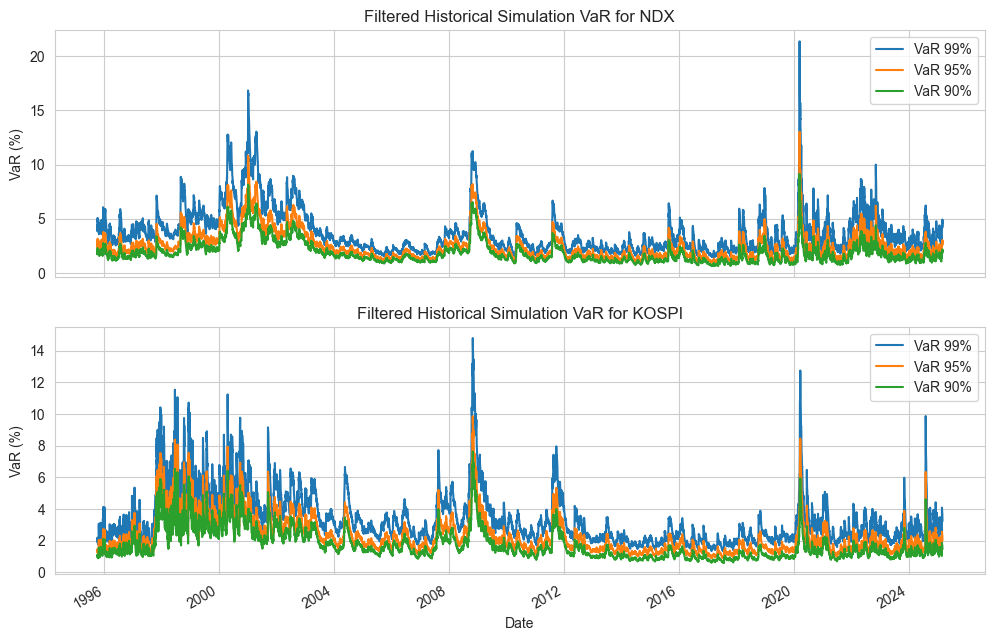

NDX VaR results saved to ndx_var_results.csv
KOSPI VaR results saved to kospi_var_results.csv


In [203]:
# Load the datasets
ndx_data = pd.read_csv("^ndx.csv")
kospi_data = pd.read_csv("^kospi.csv")

# Convert DATE column to datetime and set it as the index
ndx_data["DATE"] = pd.to_datetime(ndx_data["DATE"], format="%Y%m%d")
kospi_data["DATE"] = pd.to_datetime(kospi_data["DATE"], format="%Y%m%d")

ndx_data.set_index("DATE", inplace=True)
kospi_data.set_index("DATE", inplace=True)

# Align datasets to start on the same date
common_start_date = max(ndx_data.index.min(), kospi_data.index.min())
ndx_data = ndx_data.loc[common_start_date:]
kospi_data = kospi_data.loc[common_start_date:]

# Compute daily returns and scale by 100
ndx_data["Return"] = ((ndx_data["CLOSE"] / ndx_data["CLOSE"].shift(1)) - 1) * 100
kospi_data["Return"] = ((kospi_data["CLOSE"] / kospi_data["CLOSE"].shift(1)) - 1) * 100

# Drop NA values
ndx_data.dropna(inplace=True)
kospi_data.dropna(inplace=True)

# Set parameters
var_levels = [0.01, 0.05, 0.10]  # 1%, 5%, 10% VaR levels
update_freq = 1  # Update model daily (use 21 if updating monthly)

# Function to compute FHS VaR with a true 10-year rolling window
def filtered_historical_simulation(data, update_freq, var_levels):
    start_date = data.index.min() + pd.DateOffset(years=10)  # Define when forecasts can start
    dates = data.loc[start_date:].index  
    var_results = {alpha: [] for alpha in var_levels}

    for date in dates[::update_freq]:  # Update at chosen frequency
        train_start = date - pd.DateOffset(years=10)  # Get the start of the 10-year window
        train_data = data.loc[train_start:date]  # Select exact 10-year rolling window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals
        residuals = garch_fit.std_resid
    
        # Forecast next period's volatility
        forecasts = garch_fit.forecast(start=date, reindex=False)
        forecast_vol = np.sqrt(forecasts.variance.iloc[-1].mean())  # Extract sigma_t+1
        
        # Compute rolling mean return
        rolling_mean = garch_fit.params['mu']

        # Compute VaR for each confidence level
        for alpha in var_levels:
            residual_quantile = residuals.quantile(alpha)  # Get quantile from residuals
            var_value = - rolling_mean - forecast_vol * residual_quantile  # Compute VaR
            var_results[alpha].append((date, var_value))  # Store results

    return var_results

# Compute VaR forecasts for NDX and KOSPI using a true 10-year window
ndx_var = filtered_historical_simulation(ndx_data["Return"], update_freq, var_levels)
kospi_var = filtered_historical_simulation(kospi_data["Return"], update_freq, var_levels)

# Convert results to DataFrame (as positive %VaR)
ndx_var_df = pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in ndx_var[alpha]] for alpha in var_levels},
                           index=[v[0] for v in ndx_var[var_levels[0]]])
kospi_var_df = pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in kospi_var[alpha]] for alpha in var_levels},
                             index=[v[0] for v in kospi_var[var_levels[0]]])

# Plot VaR estimates
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# NDX VaR
ndx_var_df.plot(ax=axes[0], title="Filtered Historical Simulation VaR for NDX")
axes[0].set_ylabel("VaR (%)")

# KOSPI VaR
kospi_var_df.plot(ax=axes[1], title="Filtered Historical Simulation VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()

# Define file paths
ndx_var_filepath = "ndx_var_results.csv"
kospi_var_filepath = "kospi_var_results.csv"

# Export DataFrames to CSV
ndx_var_df.to_csv(ndx_var_filepath, index_label="Date")
kospi_var_df.to_csv(kospi_var_filepath, index_label="Date")

print(f"NDX VaR results saved to {ndx_var_filepath}")
print(f"KOSPI VaR results saved to {kospi_var_filepath}")

NDX HIT rate: 0.038882138517618466
KOSPI HIT rate: 0.04119799430817184
Correlation of HITs between NDX and KOSPI: 0.07520537788434857


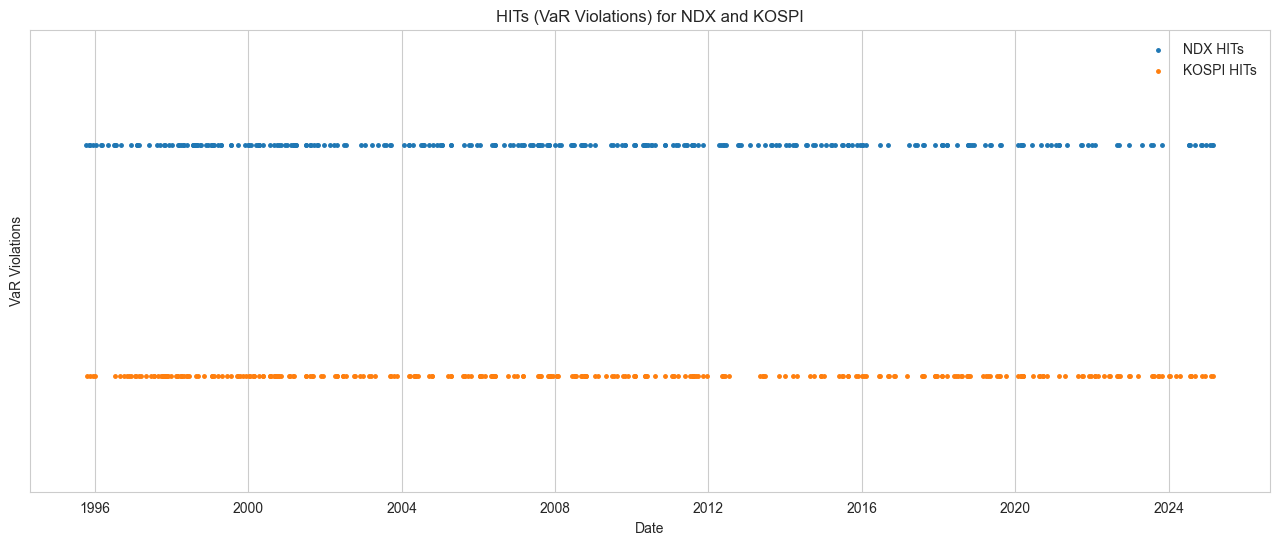

In [204]:
# Compute daily returns and scale by 100
ndx_data["Return"] = ((ndx_data["CLOSE"] / ndx_data["CLOSE"].shift(1)) - 1) * 100
kospi_data["Return"] = ((kospi_data["CLOSE"] / kospi_data["CLOSE"].shift(1)) - 1) * 100


# Select the relevant VaR columns
cols = ["VaR 95%"]  # Assuming you are using 5% VaR for hit analysis

# Combine actual returns with VaR estimates
ndx_combined = pd.concat([ndx_data["Return"], ndx_var_df[cols]], axis=1).dropna()
kospi_combined = pd.concat([kospi_data["Return"], kospi_var_df[cols]], axis=1).dropna()

# Rename columns for clarity
ndx_combined.columns = ["Return", "VaR"]
kospi_combined.columns = ["Return", "VaR"]

# Compute HIT (VaR violations) for both indices
ndx_combined["HIT"] = ndx_combined["Return"] < -ndx_combined["VaR"]
kospi_combined["HIT"] = kospi_combined["Return"] < - kospi_combined["VaR"]

# Convert HITs to float for mean/correlation calculations
ndx_hits = ndx_combined["HIT"].astype(float)
kospi_hits = kospi_combined["HIT"].astype(float)

# Define file paths
ndx_var_filepath = "ndx_combined.csv"
kospi_var_filepath = "kospi_combined.csv"

# Export DataFrames to CSV
ndx_hits.to_csv(ndx_var_filepath, index_label="Date")
kospi_hits.to_csv(kospi_var_filepath, index_label="Date")

# Print mean HIT rate (percentage of violations)
print("NDX HIT rate:", ndx_hits.mean())
print("KOSPI HIT rate:", kospi_hits.mean())

# Print correlation of HITs (if needed)
print("Correlation of HITs between NDX and KOSPI:", ndx_hits.corr(kospi_hits))

# Plot VaR Violations (HITs)
plt.figure(figsize=(16, 6))

# Modify values slightly for visualization
ndx_hits_plot = ndx_hits.replace(0.0, np.nan) + 0.05
kospi_hits_plot = kospi_hits.replace(0.0, np.nan) - 0.05

plt.scatter(ndx_hits_plot.index, ndx_hits_plot, marker=".", s=25, label="NDX HITs")
plt.scatter(kospi_hits_plot.index, kospi_hits_plot, marker=".", s=25, label="KOSPI HITs")

plt.ylim(0.9, 1.10)
plt.yticks([])
plt.ylabel("VaR Violations")
plt.xlabel("Date")
plt.legend(frameon=False)
plt.title("HITs (VaR Violations) for NDX and KOSPI")
plt.show()


In [205]:
# Compute likelihood ratio test for both indices
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    phat = hits_data.mean()  # Observed HIT rate
    llf = stats.bernoulli(phat).logpmf(hits_data).sum()  # Log-likelihood of observed rate
    llf0 = stats.bernoulli(0.05).logpmf(hits_data).sum()  # Log-likelihood under expected 5% HIT rate
    lr = 2 * (llf - llf0)  # Likelihood ratio
    pval = 1 - stats.chi2(1).cdf(lr)  # P-value from chi-squared distribution
    
    print(f"{index_name} LR: {lr:.4f} P-value: {pval:.4f}")

NDX LR: 20.8029 P-value: 0.0000
KOSPI LR: 12.7708 P-value: 0.0004


In [206]:
from scipy import stats
import numpy as np

# Perform Christoffersen's Independence Test for both indices
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit_t = hits_data.shift(1)  # Previous day's HIT
    hit_tp1 = hits_data  # Current day's HIT

    # Count transitions
    n00 = ((1 - hit_t) * (1 - hit_tp1)).sum()
    n10 = (hit_t * (1 - hit_tp1)).sum()
    n01 = ((1 - hit_t) * hit_tp1).sum()
    n11 = (hit_t * hit_tp1).sum()

    # Compute transition probabilities
    p00_hat = n00 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11_hat = n11 / (n11 + n10) if (n11 + n10) > 0 else 0

    # Compute log-likelihood for observed transition probabilities
    llf = (
        n00 * np.log(p00_hat) if p00_hat > 0 else 0
        + n10 * np.log(1 - p00_hat) if (1 - p00_hat) > 0 else 0
        + n11 * np.log(p11_hat) if p11_hat > 0 else 0
        + n10 * np.log(1 - p11_hat) if (1 - p11_hat) > 0 else 0
    )

    # Compute log-likelihood under independence assumption (p11 = 0.05)
    p11 = 0.05
    p00 = 1 - p11
    llf0 = (
        n00 * np.log(p00) if p00 > 0 else 0
        + n10 * np.log(1 - p00) if (1 - p00) > 0 else 0
        + n11 * np.log(p11) if p11 > 0 else 0
        + n10 * np.log(1 - p11) if (1 - p11) > 0 else 0
    )

    # Compute likelihood ratio test statistic
    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(2).cdf(lr)

    print(f"Christoffersen's Test, {index_name} LR: {lr} P-value: {pval}")

Christoffersen's Test, NDX LR: 156.69398861724005 P-value: 0.0
Christoffersen's Test, KOSPI LR: 142.14119503321103 P-value: 0.0


In [207]:
results = {}

for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit = hits_data - 0.05  # Adjust violations by subtracting expected 5% violation rate

    # Create lagged HIT variables (5 lags)
    lags = [hit.shift(i + 1) for i in range(5)]
    lags = pd.concat(lags, axis=1)

    # Determine corresponding VaR column
    var_col = "VaR 95%"  # Using 5% VaR estimates
    var = ndx_var_df[var_col] if index_name == "NDX" else kospi_var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Dependent variable (adjusted HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add constant term
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run OLS regression
    res = sm.OLS(y, x).fit()

    # Wald test for joint significance of all coefficients (except the constant)
    r = np.eye(len(x.columns))  # Identity matrix for joint test
    joint = res.wald_test(r, scalar=True)
    stat = joint.statistic
    pval = joint.pvalue

    # Store results
    results[index_name] = {
        "summary": res.summary(),
        "stat": f"Stat: {stat:.4f}, P-value: {pval:.4f}"
    }

# Print results
for index_name in ["NDX", "KOSPI"]:
    print(f"Regression Summary for {index_name}:")
    print(results[index_name]["summary"])
    print(f"Wald Test {index_name}: {results[index_name]['stat']}\n")


Regression Summary for NDX:
                            OLS Regression Results                            
Dep. Variable:                    HIT   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.890
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           3.83e-06
Time:                        16:31:27   Log-Likelihood:                 1677.0
No. Observations:                7402   AIC:                            -3340.
Df Residuals:                    7395   BIC:                            -3292.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0292   

In [208]:
results = {}

for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit = hits_data  # HIT variable (already 0 or 1)

    # Create lagged HIT variables (5 lags)
    lags = [hit.shift(i + 1) for i in range(5)]
    lags = pd.concat(lags, axis=1)

    # Select VaR estimate (5% VaR)
    var_col = "VaR 95%"
    var = ndx_var_df[var_col] if index_name == "NDX" else kospi_var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Binary target variable (HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add intercept
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run Logit and Probit models
    logit_model = sm.Logit(y, x).fit(disp=0)
    probit_model = sm.Probit(y, x).fit(disp=0)

    # Store results
    results[index_name] = {
        "logit_summary": logit_model.summary(),
        "probit_summary": probit_model.summary()
    }

# Print results
for index_name in ["NDX", "KOSPI"]:
    print(f"Logit Regression Summary for {index_name}:")
    print(results[index_name]["logit_summary"])
    print(f"\nProbit Regression Summary for {index_name}:")
    print(results[index_name]["probit_summary"])

Logit Regression Summary for NDX:
                           Logit Regression Results                           
Dep. Variable:                    HIT   No. Observations:                 7402
Model:                          Logit   Df Residuals:                     7395
Method:                           MLE   Df Model:                            6
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                 0.01206
Time:                        16:31:27   Log-Likelihood:                -1202.6
converged:                       True   LL-Null:                       -1217.3
Covariance Type:            nonrobust   LLR p-value:                 5.178e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6863      0.120    -30.739      0.000      -3.921      -3.451
VaR            0.1591      0.037      4.315      0.000       0.087       0.231
hit_L_1       -0.2

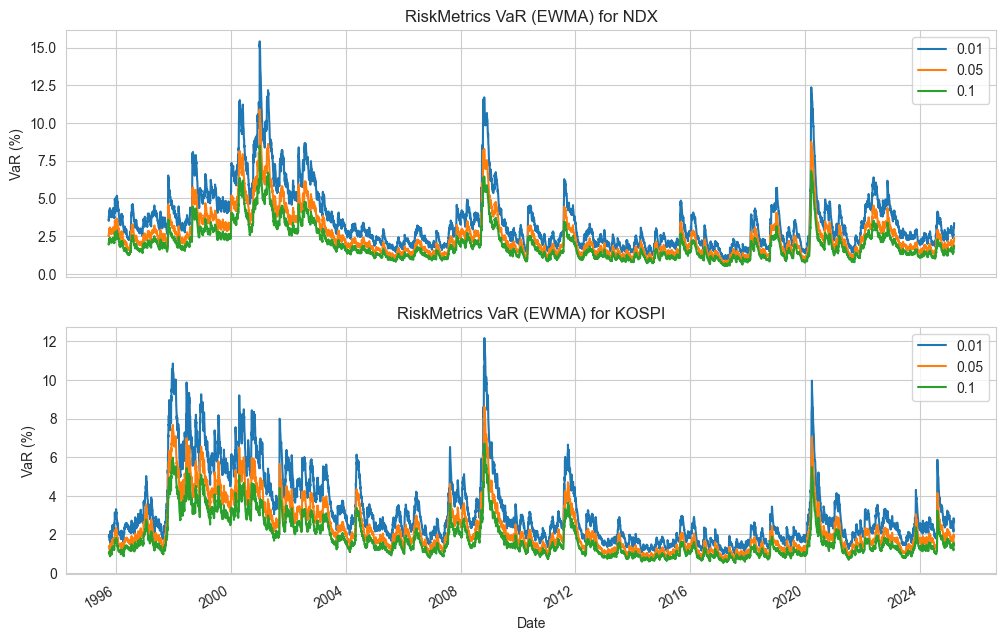

In [209]:
# Set decay factor for EWMA (RiskMetrics)
lambda_ewma = 0.94  # Daily data

# Function to compute RiskMetrics VaR using explicit summation
def riskmetrics_var_explicit(data, lambda_ewma, var_levels):
    ewma_var = np.zeros(len(data))  # Store variance estimates
    
    # Compute EWMA variance using explicit summation
    for t in range(len(data)):
        past_returns = data.iloc[:t+1]  # Take all past data up to time t
        weights = (1 - lambda_ewma) * lambda_ewma ** np.arange(len(past_returns))[::-1]  # Compute correct decay weights
        ewma_var[t] = np.sum(weights * past_returns**2)  # Apply formula

    ewma_vol = np.sqrt(ewma_var)  # Convert variance to standard deviation

    # Compute VaR for different confidence levels using normal quantiles
    var_results = {alpha: -ewma_vol * stats.norm.ppf(alpha) for alpha in var_levels}  # % VaR

    return pd.DataFrame(var_results, index=data.index)

# Compute RiskMetrics VaR for NDX and KOSPI using explicit summation
ndx_var_riskmetrics_explicit = riskmetrics_var_explicit(ndx_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])
kospi_var_riskmetrics_explicit = riskmetrics_var_explicit(kospi_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])

# Find the first date where VaR is available for NDX
first_ndx_var_date = ndx_var_df.index.min()

# Find the first date where VaR is available for KOSPI
first_kospi_var_date = kospi_var_df.index.min()

# Trim RiskMetrics VaR data to start from the same date as FHS VaR
ndx_var_riskmetrics_explicit = ndx_var_riskmetrics_explicit.loc[first_ndx_var_date:]
kospi_var_riskmetrics_explicit = kospi_var_riskmetrics_explicit.loc[first_kospi_var_date:]

# Plot RiskMetrics VaR
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# NDX VaR
ndx_var_riskmetrics_explicit.plot(ax=axes[0], title="RiskMetrics VaR (EWMA) for NDX")
axes[0].set_ylabel("VaR (%)")

# KOSPI VaR
kospi_var_riskmetrics_explicit.plot(ax=axes[1], title="RiskMetrics VaR (EWMA) for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()




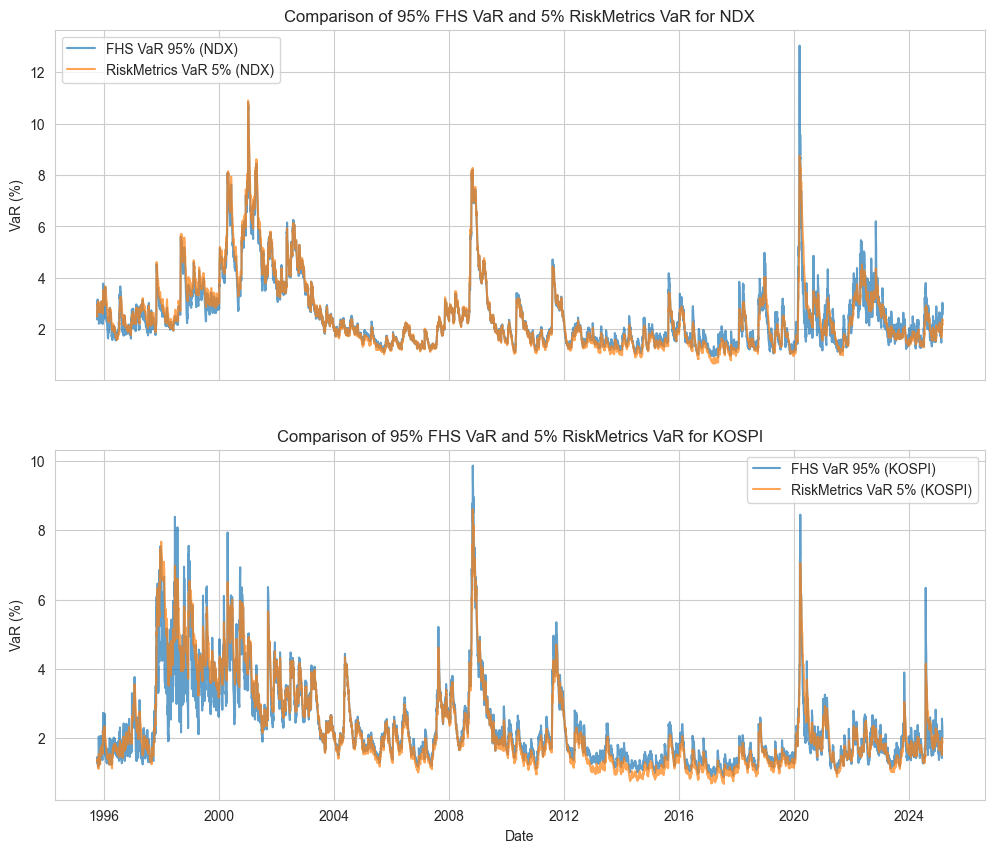

In [210]:
# Compare 5% alpha results of FHS VaR and RiskMetrics VaR
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 95% VaR for NDX
axes[0].plot(ndx_var_df.index, ndx_var_df["VaR 95%"], label="FHS VaR 95% (NDX)", linestyle="-", alpha=0.7)
axes[0].plot(ndx_var_riskmetrics_explicit.index, ndx_var_riskmetrics_explicit[0.05], label="RiskMetrics VaR 5% (NDX)", linestyle="-", alpha=0.7)
axes[0].set_title("Comparison of 95% FHS VaR and 5% RiskMetrics VaR for NDX")
axes[0].set_ylabel("VaR (%)")
axes[0].legend()

# Plot 95% VaR for KOSPI
axes[1].plot(kospi_var_df.index, kospi_var_df["VaR 95%"], label="FHS VaR 95% (KOSPI)", linestyle="-", alpha=0.7)
axes[1].plot(kospi_var_riskmetrics_explicit.index, kospi_var_riskmetrics_explicit[0.05], label="RiskMetrics VaR 5% (KOSPI)", linestyle="-", alpha=0.7)
axes[1].set_title("Comparison of 95% FHS VaR and 5% RiskMetrics VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.show()

NDX HIT rate: 0.04684757661671392
KOSPI HIT rate: 0.05312372950264264
Correlation of HITs between NDX and KOSPI: 0.08151520316480482


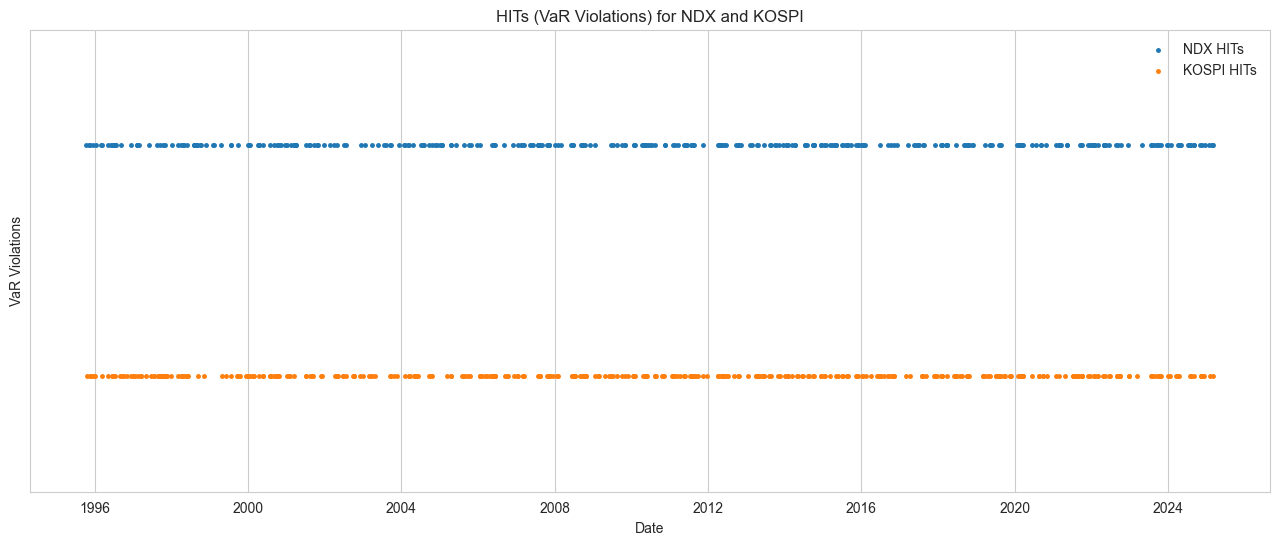

In [211]:
# Compute daily returns and scale by 100
ndx_data["Return"] = ((ndx_data["CLOSE"] / ndx_data["CLOSE"].shift(1)) - 1) * 100
kospi_data["Return"] = ((kospi_data["CLOSE"] / kospi_data["CLOSE"].shift(1)) - 1) * 100


# Select the relevant VaR columns
cols = [0.05]  # Assuming you are using 5% VaR for hit analysis

# Combine actual returns with VaR estimates
ndx_combined = pd.concat([ndx_data["Return"], ndx_var_riskmetrics_explicit[cols]], axis=1).dropna()
kospi_combined = pd.concat([kospi_data["Return"], kospi_var_riskmetrics_explicit[cols]], axis=1).dropna()

# Rename columns for clarity
ndx_combined.columns = ["Return", "VaR"]
kospi_combined.columns = ["Return", "VaR"]

# Compute HIT (VaR violations) for both indices
ndx_combined["HIT"] = ndx_combined["Return"] < -ndx_combined["VaR"]
kospi_combined["HIT"] = kospi_combined["Return"] < - kospi_combined["VaR"]

# Convert HITs to float for mean/correlation calculations
ndx_hits = ndx_combined["HIT"].astype(float)
kospi_hits = kospi_combined["HIT"].astype(float)

# Define file paths
ndx_var_filepath = "ndx_combined2.csv"
kospi_var_filepath = "kospi_combined2.csv"

# Export DataFrames to CSV
ndx_hits.to_csv(ndx_var_filepath, index_label="Date")
kospi_hits.to_csv(kospi_var_filepath, index_label="Date")

# Print mean HIT rate (percentage of violations)
print("NDX HIT rate:", ndx_hits.mean())
print("KOSPI HIT rate:", kospi_hits.mean())

# Print correlation of HITs (if needed)
print("Correlation of HITs between NDX and KOSPI:", ndx_hits.corr(kospi_hits))

# Plot VaR Violations (HITs)
plt.figure(figsize=(16, 6))

# Modify values slightly for visualization
ndx_hits_plot = ndx_hits.replace(0.0, np.nan) + 0.05
kospi_hits_plot = kospi_hits.replace(0.0, np.nan) - 0.05

plt.scatter(ndx_hits_plot.index, ndx_hits_plot, marker=".", s=25, label="NDX HITs")
plt.scatter(kospi_hits_plot.index, kospi_hits_plot, marker=".", s=25, label="KOSPI HITs")

plt.ylim(0.9, 1.10)
plt.yticks([])
plt.ylabel("VaR Violations")
plt.xlabel("Date")
plt.legend(frameon=False)
plt.title("HITs (VaR Violations) for NDX and KOSPI")
plt.show()


In [212]:
# Compute likelihood ratio test for both indices
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    phat = hits_data.mean()  # Observed HIT rate
    llf = stats.bernoulli(phat).logpmf(hits_data).sum()  # Log-likelihood of observed rate
    llf0 = stats.bernoulli(0.05).logpmf(hits_data).sum()  # Log-likelihood under expected 5% HIT rate
    lr = 2 * (llf - llf0)  # Likelihood ratio
    pval = 1 - stats.chi2(1).cdf(lr)  # P-value from chi-squared distribution
    
    print(f"{index_name} LR: {lr:.4f} P-value: {pval:.4f}")

NDX LR: 1.5815 P-value: 0.2085
KOSPI LR: 1.4868 P-value: 0.2227


In [213]:
# Perform Christoffersen's Independence Test for both indices
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit_t = hits_data.shift(1)  # Previous day's HIT
    hit_tp1 = hits_data  # Current day's HIT

    # Count transitions
    n00 = ((1 - hit_t) * (1 - hit_tp1)).sum()
    n10 = (hit_t * (1 - hit_tp1)).sum()
    n01 = ((1 - hit_t) * hit_tp1).sum()
    n11 = (hit_t * hit_tp1).sum()

    # Compute transition probabilities
    p00_hat = n00 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11_hat = n11 / (n11 + n10) if (n11 + n10) > 0 else 0

    # Compute log-likelihood for observed transition probabilities
    llf = (
        n00 * np.log(p00_hat) if p00_hat > 0 else 0
        + n10 * np.log(1 - p00_hat) if (1 - p00_hat) > 0 else 0
        + n11 * np.log(p11_hat) if p11_hat > 0 else 0
        + n10 * np.log(1 - p11_hat) if (1 - p11_hat) > 0 else 0
    )

    # Compute log-likelihood under independence assumption (p11 = 0.05)
    p11 = 0.05
    p00 = 1 - p11
    llf0 = (
        n00 * np.log(p00) if p00 > 0 else 0
        + n10 * np.log(1 - p00) if (1 - p00) > 0 else 0
        + n11 * np.log(p11) if p11 > 0 else 0
        + n10 * np.log(1 - p11) if (1 - p11) > 0 else 0
    )

    # Compute likelihood ratio test statistic
    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(2).cdf(lr)

    print(f"Christoffersen's Test, {index_name} LR: {lr} P-value: {pval}")

Christoffersen's Test, NDX LR: 39.95929099993009 P-value: 2.1035372332889324e-09
Christoffersen's Test, KOSPI LR: -19.38581586131113 P-value: 1.0


In [214]:
results = {}

for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit = hits_data - 0.05  # Adjust violations by subtracting expected 5% violation rate

    # Create lagged HIT variables (5 lags)
    lags = [hit.shift(i + 1) for i in range(5)]
    lags = pd.concat(lags, axis=1)

    # Determine corresponding VaR column
    var_col = "VaR 95%"  # Using 5% VaR estimates
    var = ndx_var_df[var_col] if index_name == "NDX" else kospi_var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Dependent variable (adjusted HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add constant term
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run OLS regression
    res = sm.OLS(y, x).fit()

    # Wald test for joint significance of all coefficients (except the constant)
    r = np.eye(len(x.columns))  # Identity matrix for joint test
    joint = res.wald_test(r, scalar=True)
    stat = joint.statistic
    pval = joint.pvalue

    # Store results
    results[index_name] = {
        "summary": res.summary(),
        "stat": f"Stat: {stat:.4f}, P-value: {pval:.4f}"
    }

# Print results
for index_name in ["NDX", "KOSPI"]:
    print(f"Regression Summary for {index_name}:")
    print(results[index_name]["summary"])
    print(f"Wald Test {index_name}: {results[index_name]['stat']}\n")


Regression Summary for NDX:
                            OLS Regression Results                            
Dep. Variable:                    HIT   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.047
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           1.70e-07
Time:                        16:31:32   Log-Likelihood:                 1021.5
No. Observations:                7402   AIC:                            -2029.
Df Residuals:                    7395   BIC:                            -1981.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0204   

In [215]:
results = {}

for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits, kospi_hits]):
    hit = hits_data  # HIT variable (already 0 or 1)

    # Create lagged HIT variables (5 lags)
    lags = [hit.shift(i + 1) for i in range(5)]
    lags = pd.concat(lags, axis=1)

    # Select VaR estimate (5% VaR)
    var_col = "VaR 95%"
    var = ndx_var_df[var_col] if index_name == "NDX" else kospi_var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Binary target variable (HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add intercept
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run Logit and Probit models
    logit_model = sm.Logit(y, x).fit(disp=0)
    probit_model = sm.Probit(y, x).fit(disp=0)

    # Store results
    results[index_name] = {
        "logit_summary": logit_model.summary(),
        "probit_summary": probit_model.summary()
    }

# Print results
for index_name in ["NDX", "KOSPI"]:
    print(f"Logit Regression Summary for {index_name}:")
    print(results[index_name]["logit_summary"])
    print(f"\nProbit Regression Summary for {index_name}:")
    print(results[index_name]["probit_summary"])

Logit Regression Summary for NDX:
                           Logit Regression Results                           
Dep. Variable:                    HIT   No. Observations:                 7402
Model:                          Logit   Df Residuals:                     7395
Method:                           MLE   Df Model:                            6
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                 0.01256
Time:                        16:31:32   Log-Likelihood:                -1383.0
converged:                       True   LL-Null:                       -1400.6
Covariance Type:            nonrobust   LLR p-value:                 3.979e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4352      0.111    -30.853      0.000      -3.653      -3.217
VaR            0.1301      0.035      3.725      0.000       0.062       0.199
hit_L_1       -0.2

In [ ]:
# Align daily returns with VaR data
ndx_returns = ndx_data["Return"].loc[ndx_var_riskmetrics_explicit.index]
kospi_returns = kospi_data["Return"].loc[kospi_var_riskmetrics_explicit.index]

# Align FHS VaR with RiskMetrics VaR for comparison
ndx_var_fhs_series = ndx_var_df["VaR 95%"].loc[ndx_var_riskmetrics_explicit.index]
kospi_var_fhs_series = kospi_var_df["VaR 95%"].loc[kospi_var_riskmetrics_explicit.index]

# Convert VaRs to negative values (representing expected losses)
ndx_var_riskmetrics_actual = -ndx_var_riskmetrics_explicit[0.05]
ndx_var_fhs_actual = -ndx_var_fhs_series

kospi_var_riskmetrics_actual = -kospi_var_riskmetrics_explicit[0.05]
kospi_var_fhs_actual = -kospi_var_fhs_series

# Define tick loss function
def tick_loss(returns, var_estimates, alpha=0.05):
    indicator = (returns < var_estimates).astype(int)
    return alpha * (returns - var_estimates) * (1 - indicator) + (1 - alpha) * (var_estimates - returns) * indicator

# Compute tick losses for both models (NDX)
ndx_loss_riskmetrics = tick_loss(ndx_returns, ndx_var_riskmetrics_actual, alpha=0.05)
ndx_loss_fhs = tick_loss(ndx_returns, ndx_var_fhs_actual, alpha=0.05)

# Compute tick losses for both models (KOSPI)
kospi_loss_riskmetrics = tick_loss(kospi_returns, kospi_var_riskmetrics_actual, alpha=0.05)
kospi_loss_fhs = tick_loss(kospi_returns, kospi_var_fhs_actual, alpha=0.05)

# Compute loss differences
ndx_d_t = ndx_loss_riskmetrics - ndx_loss_fhs
kospi_d_t = kospi_loss_riskmetrics - kospi_loss_fhs

# Compute DM statistic function
def compute_dm_stat(d_t):
    mean_d = d_t.mean()  # Mean of loss differences
    long_run_var = sm.tsa.stattools.acovf(d_t, fft=True, nlag=5)[0]  # Newey-West HAC variance

    # Avoid division by zero
    if long_run_var > 0:
        dm_stat = mean_d / np.sqrt(long_run_var / len(d_t))
    else:
        dm_stat = np.nan

    # Compute p-value (two-tailed test)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    
    return dm_stat, p_value

# Compute DM statistics for NDX and KOSPI
ndx_dm_stat, ndx_p_value = compute_dm_stat(ndx_d_t)
kospi_dm_stat, kospi_p_value = compute_dm_stat(kospi_d_t)

# Print results
print(f"Diebold-Mariano Test for NDX (RiskMetrics vs. FHS) -> DM Stat: {ndx_dm_stat:.4f}, P-value: {ndx_p_value:.4f}")
print(f"Diebold-Mariano Test for KOSPI (RiskMetrics vs. FHS) -> DM Stat: {kospi_dm_stat:.4f}, P-value: {kospi_p_value:.4f}")


Diebold-Mariano Test for NDX (RiskMetrics vs. FHS) -> DM Stat: 8.3520, P-value: 0.0000
Diebold-Mariano Test for KOSPI (RiskMetrics vs. FHS) -> DM Stat: 11.5552, P-value: 0.0000


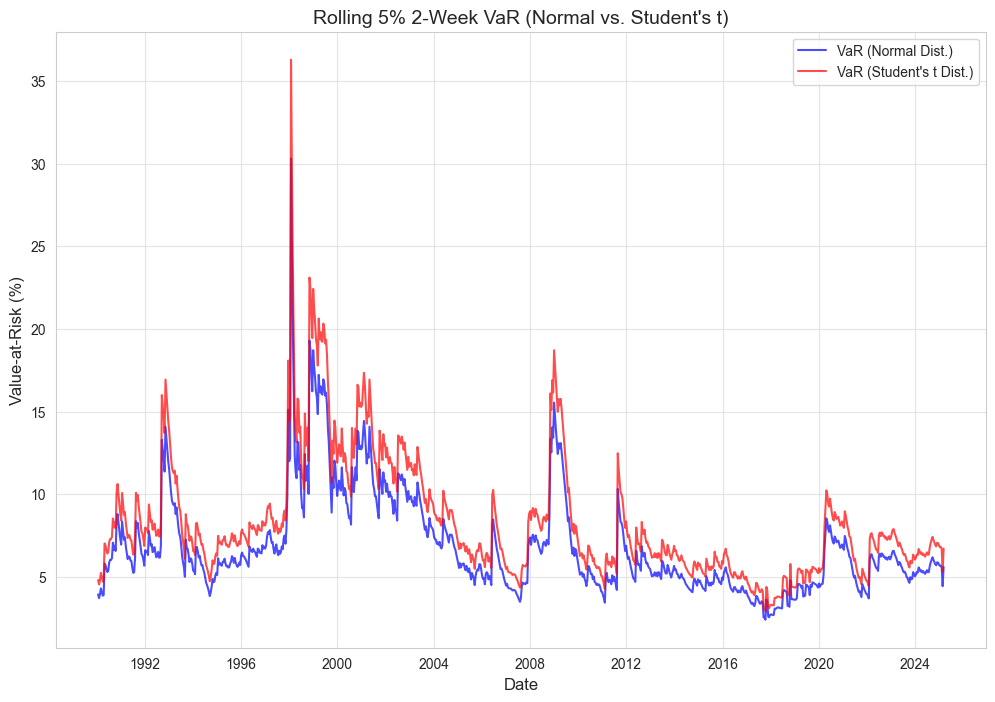

In [217]:
kospi = pd.read_csv("^kospi.csv", parse_dates=["DATE"], index_col="DATE")
ndx = pd.read_csv("^ndx.csv")

kospi = kospi.sort_index()

# Resample to get Thursday closing prices (weekly)
thursday_prices = kospi.resample("W-THU").last()

# Select every second Thursday to get non-overlapping 2-week returns
non_overlapping_thursdays = thursday_prices.iloc[::2]

# Compute non-overlapping returns
returns = ((non_overlapping_thursdays["CLOSE"] / non_overlapping_thursdays["CLOSE"].shift(1)) - 1) * 100
returns = returns.dropna()  # Remove any NaN values that result from the shift

# get first 10 years
start_date = returns.index.min()  # Get the first available date
end_date = start_date + pd.DateOffset(years=10)  # Add 10 years to the start date

# Filter the returns to get the first 10 years
first_10_years_returns = returns[(returns.index >= start_date) & (returns.index < end_date)]

# 5. Fit a GARCH(1,1) model to the initial sample with a constant mean
garch_model = arch_model(first_10_years_returns, vol='Garch', p=1, q=1, mean='Constant')
garch_fit = garch_model.fit(disp="off")

# 6. Calculate the 5% 2-week VaR using the GARCH model
# Forecast the volatility for the next 2-week period
forecast_horizon = 1  # 1-step ahead forecast for the next 2 weeks (since returns are biweekly)
forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract the volatility forecast for the 2-week horizon
volatility_forecast = forecast.variance.values ** 0.5  # square root for volatility

estimated_mean = garch_fit.params['mu']

# Calculate the 5% VaR for the 2-week horizon using the normal distribution
confidence_level = 0.05

# SHOULD WE ASSUME e is NORMAL?

z_score = norm.ppf(confidence_level)  # Get the z-score for the 5% level
VaR_5_percent_norm = -estimated_mean -z_score * volatility_forecast  # The VaR is negative because it represents a loss

# assume e follows t-dist
params = stats.t.fit(first_10_years_returns)


# Extract the degrees of freedom (df) from the fitted parameters
degrees_of_freedom = params[0]

t_quantile = t.ppf(confidence_level, df=degrees_of_freedom)

VaR_5_percent_t = -estimated_mean - t_quantile * volatility_forecast

# 8. Update model: Rolling window
window_size = len(first_10_years_returns)  # Rolling window size

# Initialize an empty list to store VaR values
var_5_percent_norm_list = []
var_5_percent_t_list = []

# Loop through rolling windows
for i in range(len(returns) - window_size):
    rolling_sample = returns.iloc[i : i + window_size]  # Get the rolling window sample

    # Fit a GARCH(1,1) model to the rolling sample
    garch_model = arch_model(rolling_sample, vol='Garch', p=1, q=1, mean='Constant')
    garch_fit = garch_model.fit(disp="off")  # Suppress output

    # Forecast the volatility for the next 2-week period
    forecast = garch_fit.forecast(horizon=1)
    volatility_forecast = np.sqrt(forecast.variance.iloc[-1].mean())  # Extract latest forecasted volatility

    # Estimated mean return
    estimated_mean = garch_fit.params['mu']

    # Compute VaR
    VaR_5_p_norm = -estimated_mean - z_score * volatility_forecast  
    VaR_5_p_t = -estimated_mean - t_quantile * volatility_forecast
    var_5_percent_norm_list.append(VaR_5_p_norm)
    var_5_percent_t_list.append(VaR_5_p_t)

# Convert the VaR list to a DataFrame with timestamps
var_norm_series = pd.Series(var_5_percent_norm_list, index=returns.index[window_size:])
var_t_series = pd.Series(var_5_percent_t_list, index=returns.index[window_size:])

# Plot the two VaR series
plt.figure(figsize=(12, 8))
plt.plot(var_norm_series, label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(var_t_series, label="VaR (Student's t Dist.)", linestyle="-", color="red", alpha=0.7)

# Add titles and labels
plt.title("Rolling 5% 2-Week VaR (Normal vs. Student's t)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="-", alpha=0.5)

# Show the plot
plt.show()

In [218]:
# Assuming 'returns' is the actual 2-week return series
# and var_norm_series (Normal VaR) & var_t_series (Filtered Historical Simulation VaR) are VaR estimates
alpha = 0.05  # 5% confidence level

# Ensure all datasets have matching timestamps
returns = returns.loc[var_norm_series.index]  # Align returns with the VaR series
var_t_series = var_t_series.loc[var_norm_series.index]

# **NEGATE VaR since it is stored as a positive number**
var_norm_series_actual = -var_norm_series
var_t_series_actual = -var_t_series

# Define tick loss function (corrected for positive VaR)
def tick_loss(returns, var_estimates, alpha=0.05):
    indicator = (returns < var_estimates).astype(int)
    return alpha * (returns - var_estimates) * (1 - indicator) + (1 - alpha) * (var_estimates - returns) * indicator

# Compute loss for both models
loss_A = tick_loss(returns, var_norm_series_actual, alpha)  # Normal VaR
loss_B = tick_loss(returns, var_t_series_actual, alpha)  # Filtered Historical Simulation VaR

# Compute loss differences
d_t = loss_A - loss_B

# Compute the DM statistic
mean_d = d_t.mean()  # Mean difference
long_run_var = sm.tsa.stattools.acovf(d_t, fft=True, nlag=5)[0]  # HAC variance (Newey-West)

# Avoid division by zero
if long_run_var > 0:
    DM_stat = mean_d / np.sqrt(long_run_var / len(d_t))
else:
    DM_stat = np.nan

# Compute p-value (assuming normality)
p_value = 2 * (1 - stats.norm.cdf(abs(DM_stat)))  # Two-tailed test

print(f"Diebold-Mariano Test Statistic: {DM_stat:.4f}, P-value: {p_value:.4f}")

Diebold-Mariano Test Statistic: -1.9970, P-value: 0.0458


<Figure size 1200x800 with 0 Axes>

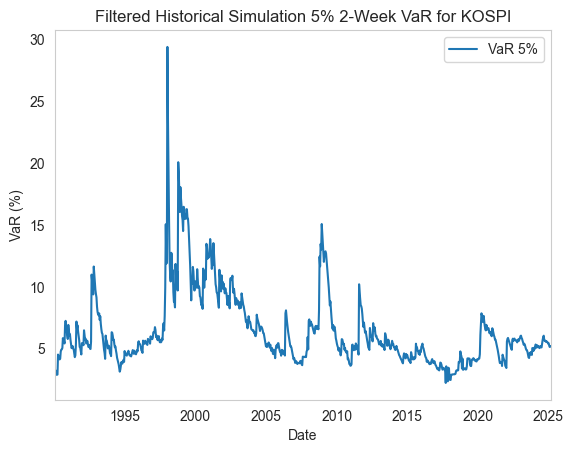

In [219]:
# Load dataset
kospi_data_fuckoff = pd.read_csv("^kospi.csv", parse_dates=["DATE"], index_col="DATE")
kospi_data_fuckoff = kospi_data_fuckoff.sort_index()

# Resample to get Thursday closing prices (biweekly)
thursday_prices = kospi_data_fuckoff.resample("W-THU").last()

# Select every second Thursday for non-overlapping 2-week returns
biweekly_prices = thursday_prices.iloc[::2]

# Compute non-overlapping 2-week returns and scale by 100
biweekly_returns = ((biweekly_prices["CLOSE"] / biweekly_prices["CLOSE"].shift(1)) - 1) * 100
biweekly_returns.dropna(inplace=True)

# Set parameters
var_level = 0.05  # 5% VaR
update_freq = 1  # Update model at each available 2-week period

# Function to compute 5% 2-week VaR with a rolling 10-year window
def filtered_historical_simulation(data, update_freq, var_level):
    start_date = data.index.min() + pd.DateOffset(years=10)  # Define when forecasts start
    dates = data.loc[start_date:].index  # Forecasting starts after 10-year window
    var_results = []

    for date in dates[::update_freq]:  # Update at chosen frequency
        train_start = date - pd.DateOffset(years=10)  # Get start of rolling window
        train_data = data.loc[train_start:date]  # Select 10-year window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals
        residuals = garch_fit.std_resid

        # Forecast next period's volatility (2-week ahead)
        forecasts = garch_fit.forecast(start=date, reindex=False)
        forecast_vol = np.sqrt(forecasts.variance.iloc[-1].mean())  # Extract sigma_t+1

        # Compute rolling mean return
        rolling_mean = garch_fit.params['mu']
        residual_quantile = residuals.quantile(var_level) 

        # Compute 5% 2-week VaR
        var_value = - rolling_mean - forecast_vol * residual_quantile  # Compute VaR
        var_results.append((date, var_value))  # Store results

    return var_results

# Compute 5% 2-week VaR forecasts for KOSPI
kospi_var_fuck = filtered_historical_simulation(biweekly_returns, update_freq, var_level)

# Convert results to DataFrame (as positive %VaR)
kospi_var_fuck_df = pd.DataFrame({"VaR 5%": [v[1] for v in kospi_var_fuck]}, index=[v[0] for v in kospi_var_fuck])

# Plot 5% 2-week VaR estimates
plt.figure(figsize=(12, 8))
kospi_var_fuck_df.plot(title="Filtered Historical Simulation 5% 2-Week VaR for KOSPI", legend=True)
plt.ylabel("VaR (%)")
plt.xlabel("Date")
plt.grid()
plt.show()


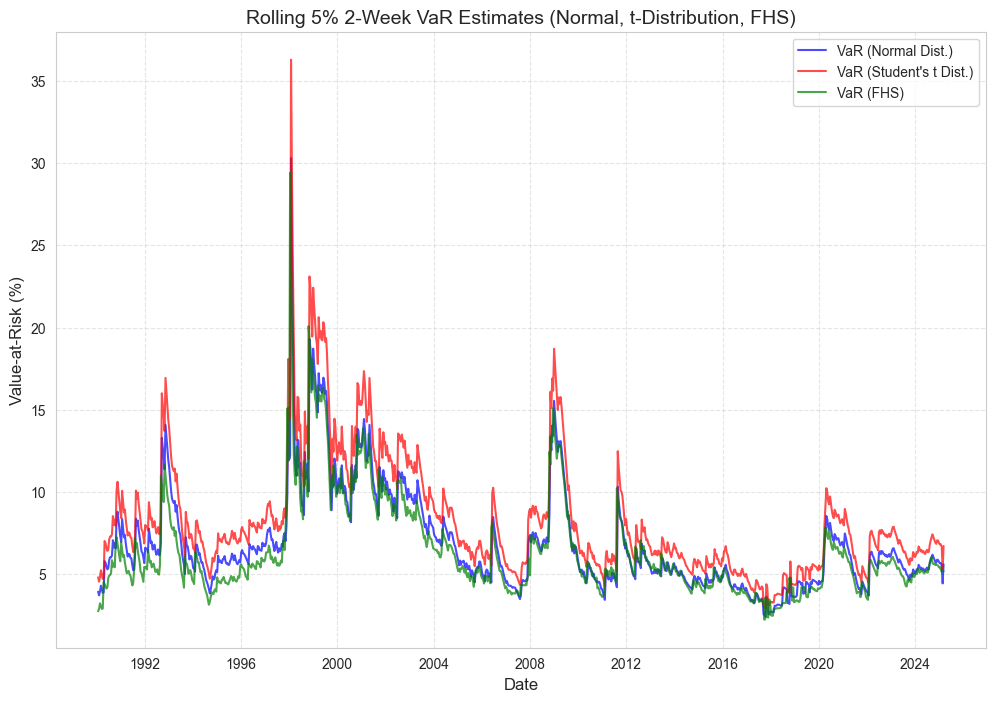

In [220]:
# Ensure all series have the same date index range
combined_df = pd.concat([var_norm_series, var_t_series, kospi_var_fuck_df["VaR 5%"]], axis=1)
combined_df.columns = ["VaR (Normal Dist.)", "VaR (Student's t Dist.)", "VaR (FHS)"]
combined_df.dropna(inplace=True)  # Drop any missing values to align series

# Plot the three VaR estimates in one graph
plt.figure(figsize=(12, 8))
plt.plot(combined_df.index, combined_df["VaR (Normal Dist.)"], label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(combined_df.index, combined_df["VaR (Student's t Dist.)"], label="VaR (Student's t Dist.)", linestyle="-", color="red", alpha=0.7)
plt.plot(combined_df.index, combined_df["VaR (FHS)"], label="VaR (FHS)", linestyle="-", color="green", alpha=0.7)

# Add title, labels, and legend
plt.title("Rolling 5% 2-Week VaR Estimates (Normal, t-Distribution, FHS)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

In [221]:
# Align returns with VaR data
returns = biweekly_returns.loc[var_norm_series.index]  
var_fhs_series = kospi_var_fuck_df["VaR 5%"].loc[var_norm_series.index]

# Convert VaRs to negative values since they represent potential losses
var_norm_series_actual = -var_norm_series  # Normal VaR (converted to negative)
var_fhs_series_actual = -var_fhs_series  # FHS VaR (converted to negative)

# Define tick loss function
def tick_loss(returns, var_estimates, alpha=0.05):
    indicator = (returns < var_estimates).astype(int)
    return alpha * (returns - var_estimates) * (1 - indicator) + (1 - alpha) * (var_estimates - returns) * indicator

# Compute tick losses for both models
loss_norm = tick_loss(returns, var_norm_series_actual, alpha=0.05)  # Normal VaR
loss_fhs = tick_loss(returns, var_fhs_series_actual, alpha=0.05)  # FHS VaR

# Compute loss differences
d_t = loss_norm - loss_fhs

# Compute DM statistic
mean_d = d_t.mean()  # Mean of loss differences
long_run_var = sm.tsa.stattools.acovf(d_t, fft=True, nlag=5)[0]  # Newey-West HAC variance

# Avoid division by zero
if long_run_var > 0:
    DM_stat = mean_d / np.sqrt(long_run_var / len(d_t))
else:
    DM_stat = np.nan

# Compute p-value (two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(DM_stat)))

# Print results
print(f"Diebold-Mariano Test Statistic: {DM_stat:.4f}, P-value: {p_value:.4f}")


Diebold-Mariano Test Statistic: 6.0541, P-value: 0.0000


KOSPI HIT rate (Normal VaR): 0.05779716466739367
KOSPI HIT rate (FHS VaR): 0.04798255179934569
Correlation of HITs (Normal vs FHS): 0.818979796227169


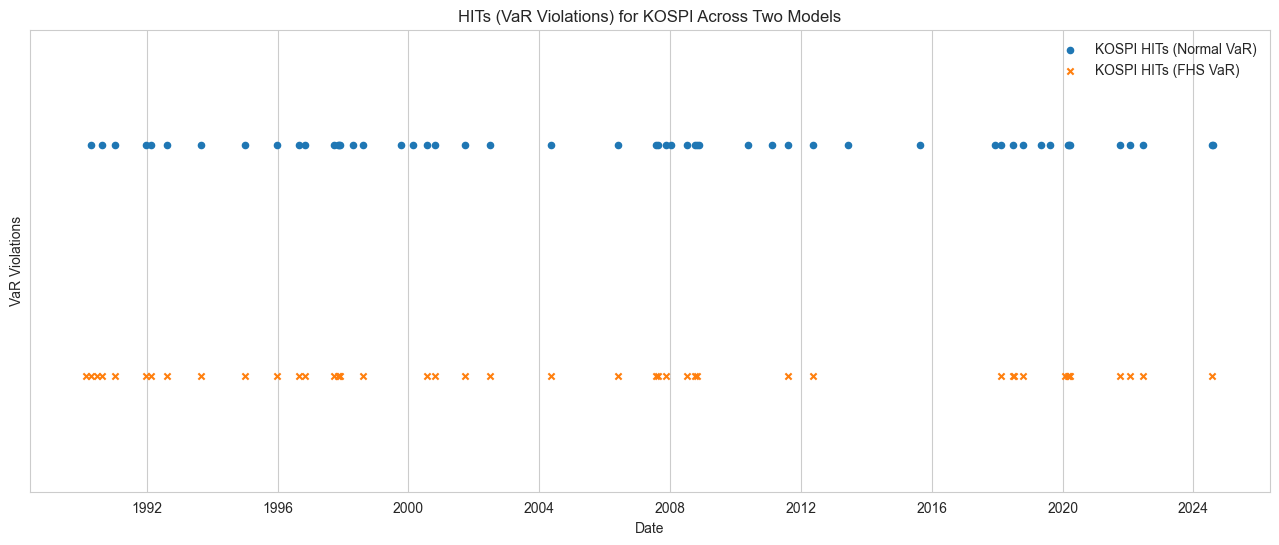

In [222]:
# Ensure all datasets have matching timestamps
returns = biweekly_returns.loc[var_norm_series.index]  
var_fhs_series = kospi_var_fuck_df["VaR 5%"].loc[var_norm_series.index]

# Convert VaRs to negative values since they represent potential losses
var_norm_series_actual = -var_norm_series  # Normal VaR (converted to negative)
var_fhs_series_actual = -var_fhs_series  # FHS VaR (converted to negative)

# Compute HITs (VaR violations) for KOSPI
hit_norm = (returns < var_norm_series_actual).astype(float)  # HIT for Normal VaR
hit_fhs = (returns < var_fhs_series_actual).astype(float)  # HIT for FHS VaR

# Save results to CSV
kospi_hits_df = pd.DataFrame({
    "Return": returns,
    "VaR_Normal": var_norm_series_actual,
    "VaR_FHS": var_fhs_series_actual,
    "HIT_Normal": hit_norm,
    "HIT_FHS": hit_fhs
})

# Save to CSV
kospi_hits_df.to_csv("kospi_hits_comparison.csv", index_label="Date")

# Print mean HIT rates (percentage of violations)
print("KOSPI HIT rate (Normal VaR):", hit_norm.mean())
print("KOSPI HIT rate (FHS VaR):", hit_fhs.mean())

# Compute and print correlation of HITs between models
hit_correlation = hit_norm.corr(hit_fhs)
print("Correlation of HITs (Normal vs FHS):", hit_correlation)

# Plot VaR Violations (HITs) for both models
plt.figure(figsize=(16, 6))

# Modify values slightly for visualization
hit_norm_plot = hit_norm.replace(0.0, np.nan) + 0.05
hit_fhs_plot = hit_fhs.replace(0.0, np.nan) - 0.05

plt.scatter(hit_norm_plot.index, hit_norm_plot, marker="o", s=20, label="KOSPI HITs (Normal VaR)")
plt.scatter(hit_fhs_plot.index, hit_fhs_plot, marker="x", s=20, label="KOSPI HITs (FHS VaR)")

plt.ylim(0.9, 1.10)
plt.yticks([])
plt.ylabel("VaR Violations")
plt.xlabel("Date")
plt.legend(frameon=False)
plt.title("HITs (VaR Violations) for KOSPI Across Two Models")
plt.show()
